In [25]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from PIL import Image


##Image Settings

In [27]:
IMAGE_SIZE = [176,208]                                              
BATCH_SIZE = 5000                                                
bright_range = [.8,1.2]    
zoom = [.99,1.01]                                               
layers_unlocked = True          
lr = 0.01                                                           
batch = 20                                                          
EPOCHS = 50                                                              
                                                   

##Importing Data

In [28]:
from zipfile import ZipFile
file_name = "dataset_alzheimer.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


##Data Augmentation

In [29]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    fill_mode='constant',
    cval=0,
    brightness_range=bright_range,
    zoom_range=zoom,
    data_format='channels_last',
    zca_whitening=False
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    fill_mode='constant',
    cval=0,
    zoom_range=[1,1],  
    data_format='channels_last'
)



train_data_gen = train_datagen.flow_from_directory(
    directory='Alzheimer_s Dataset/train',  #replace with path to folder with training data
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,  
    class_mode='categorical'  
)

test_data_gen = test_datagen.flow_from_directory(
    directory='Alzheimer_s Dataset/test',  #replace with path to folder with test data
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,  
    class_mode='categorical'  
)


Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [30]:
train_data,train_labels =  train_data_gen.next()
test_data,test_labels = test_data_gen.next()

In [31]:
X = np.concatenate((train_data,test_data))
y = np.concatenate((train_labels,test_labels))
print(X.shape)
print(y.shape)

(6279, 176, 208, 3)
(6279, 4)


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

print('train: ',X_train.shape)
print('test',X_test.shape)
                                

train:  (5023, 176, 208, 3)
test (1256, 176, 208, 3)


##Viewing example MRI Images

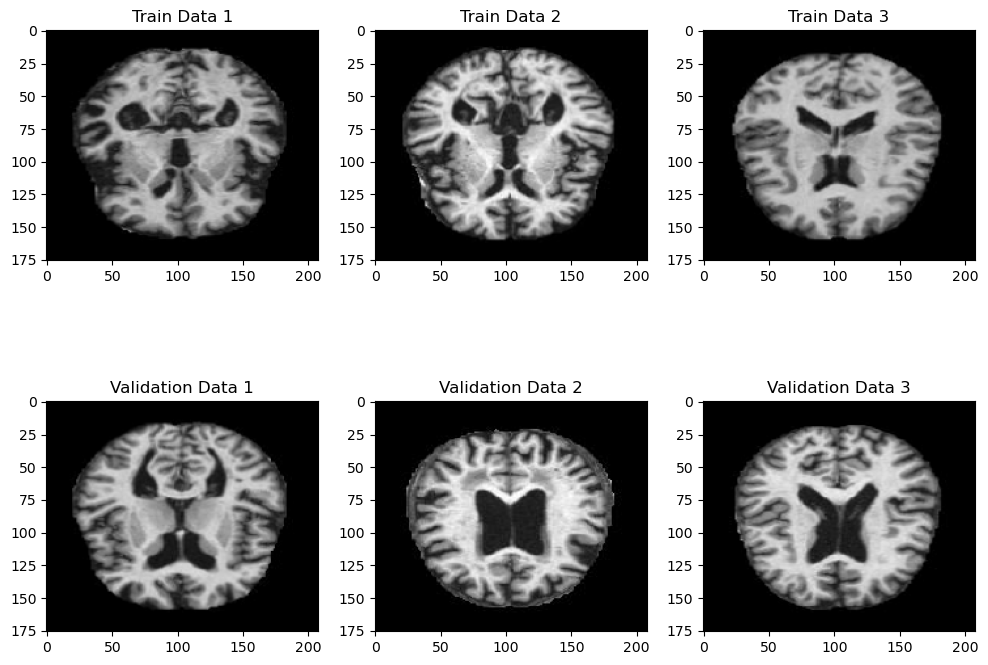

In [33]:
plt.figure(figsize=(10, 8))

plt.subplot(231)
plt.imshow(X_train[0, :, :, :])
plt.title('Train Data 1')

plt.subplot(232)
plt.imshow(X_train[1, :, :, :])
plt.title('Train Data 2')

plt.subplot(233)
plt.imshow(X_train[2, :, :, :])
plt.title('Train Data 3')

plt.subplot(234)
plt.imshow(X_test[0, :, :, :])
plt.title('Test Data 1')

plt.subplot(235)
plt.imshow(X_test[1, :, :, :])
plt.title('Test Data 2')

plt.subplot(236)
plt.imshow(X_test[2, :, :, :])
plt.title('Test Data 3')

plt.tight_layout()  
plt.show()

##Define Convolutional and Dense Layers

In [13]:
def convolutional_layer(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [34]:
def dense_layer(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

##Build Model

In [35]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
    
        tf.keras.layers.MaxPool2D(),
        
        convolutional_layer(32),
        convolutional_layer(64),
        convolutional_layer(128),
        
        tf.keras.layers.Dropout(0.2),
        
        conv_layer(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_layer(512, 0.7),
        dense_layer(128, 0.5),
        dense_layer(64, 0.3),
        
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    
    return model

In [36]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [38]:
with strategy.scope():
    modelCategorical = build_model()

    METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc')
]
    
    modelCategorical.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

Save Model History and Metrics Across Epochs

In [39]:
model_history = modelCategorical.fit(X_train, y_train, validation_data=(X_test, y_test),
                          epochs=EPOCHS, batch_size=batch, shuffle=True)

Epoch 1/50
252/252 [==============================] - 78s 307ms/step - loss: 1.4992 - accuracy: 0.3777 - precision: 0.4190 - recall: 0.2451 - auc: 0.6453 - val_loss: 1.1387 - val_accuracy: 0.5119 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7837
Epoch 2/50
252/252 [==============================] - 86s 342ms/step - loss: 1.1088 - accuracy: 0.4822 - precision: 0.5529 - recall: 0.3301 - auc: 0.7757 - val_loss: 1.0246 - val_accuracy: 0.5119 - val_precision: 0.5226 - val_recall: 0.5056 - val_auc: 0.8127
Epoch 3/50
252/252 [==============================] - 86s 340ms/step - loss: 0.9998 - accuracy: 0.5182 - precision: 0.6041 - recall: 0.3488 - auc: 0.8109 - val_loss: 1.0922 - val_accuracy: 0.3646 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7450
Epoch 4/50
252/252 [==============================] - 90s 358ms/step - loss: 0.9396 - accuracy: 0.5405 - precision: 0.6491 - recall: 0.3506 - auc: 0.8289 - val_loss: 0.9737 - val_accuracy: 0.5104 - val_preci

In [41]:
pred_labels = modelCategorical.predict(test_data)

40/40 [==============================] - 5s 118ms/step


In [42]:
_ = modelCategorical.evaluate(test_data, test_labels)

40/40 [==============================] - 5s 120ms/step - loss: 0.0672 - accuracy: 0.9789 - precision: 0.9797 - recall: 0.9789 - auc: 0.9986


In [50]:
modelCategorical.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 176, 208, 16)      448       
                                                                 
 conv2d_5 (Conv2D)           (None, 176, 208, 16)      2320      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 88, 104, 16)      0         
 g2D)                                                            
                                                                 
 sequential_16 (Sequential)  (None, 44, 52, 32)        2160      
                                                                 
 sequential_17 (Sequential)  (None, 22, 26, 64)        7392      
                                                                 
 sequential_18 (Sequential)  (None, 11, 13, 128)       27072     
                                                     

##Plots of model Metrics

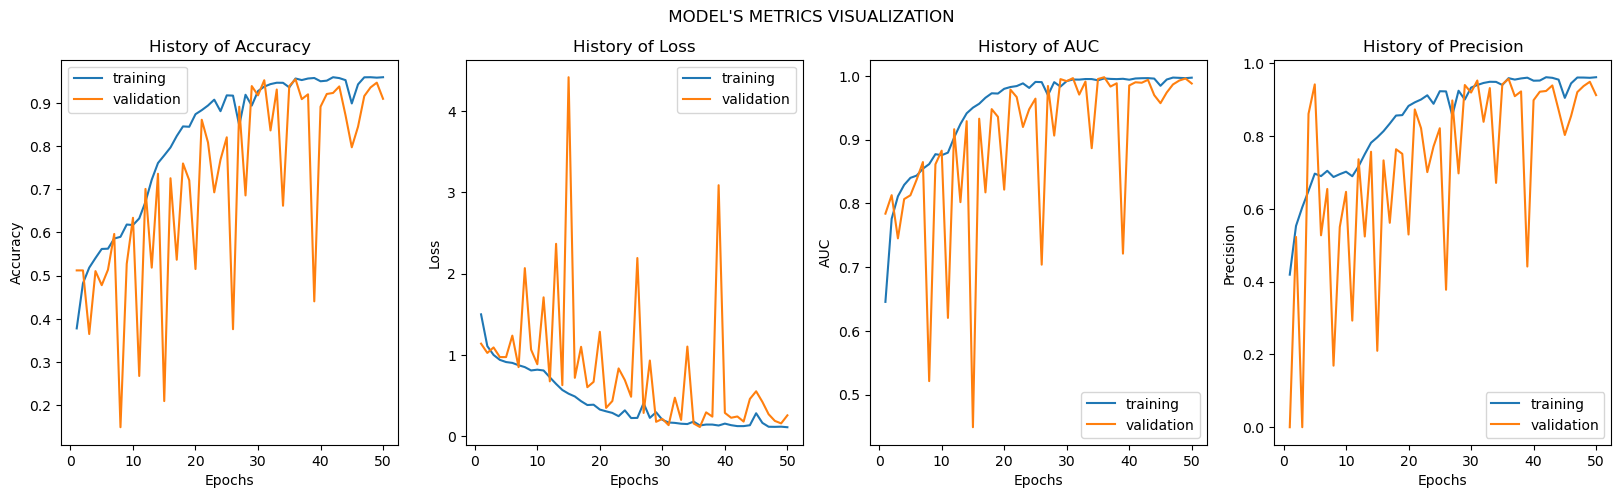

In [51]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):
    
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    

    plt.show()
    

Train_Val_Plot(model_history.history['accuracy'],model_history.history['val_accuracy'],
               model_history.history['loss'],model_history.history['val_loss'],
               model_history.history['auc'],model_history.history['val_auc'],
              model_history.history['precision'],model_history.history['val_precision']              )

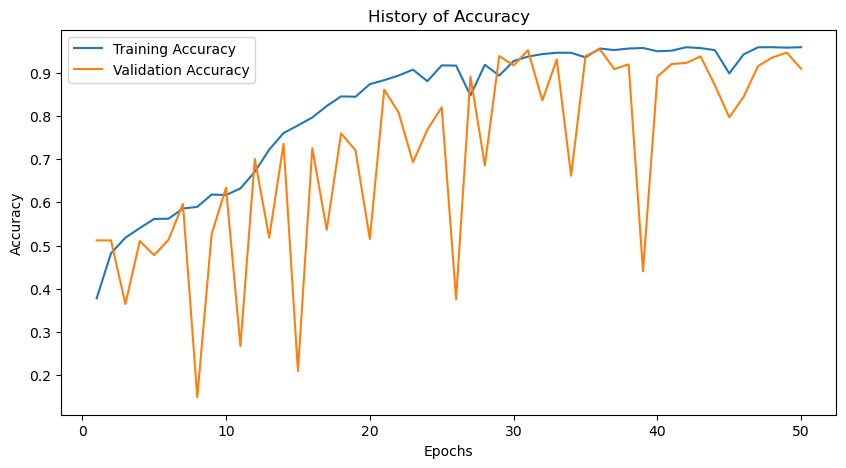

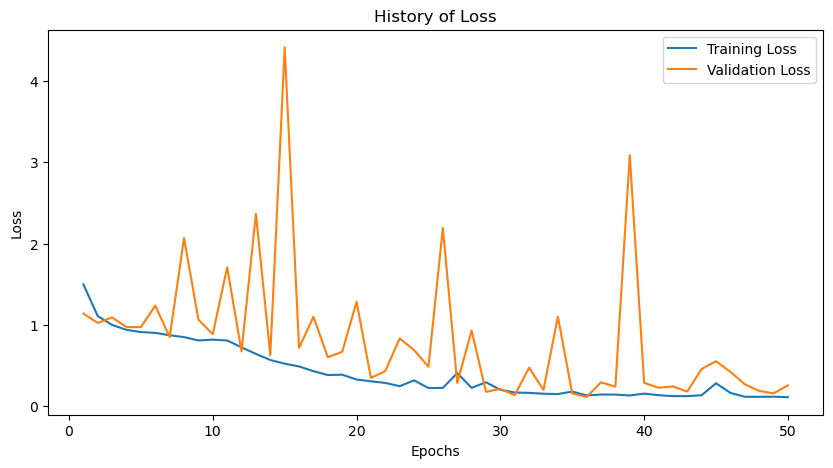

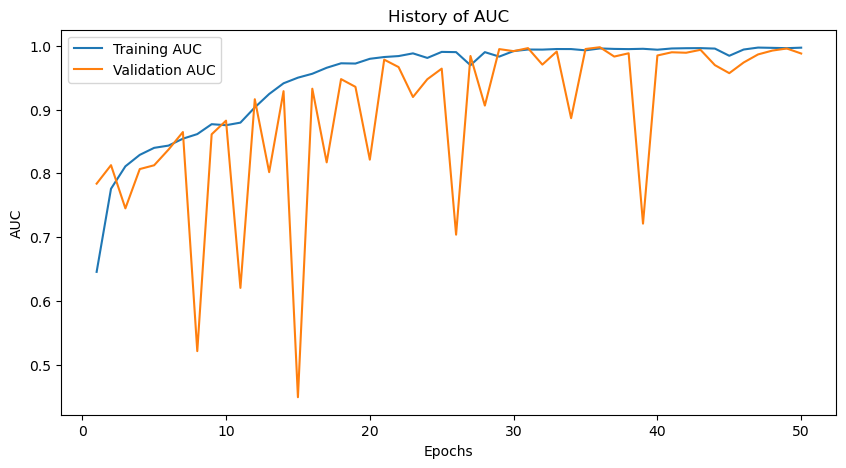

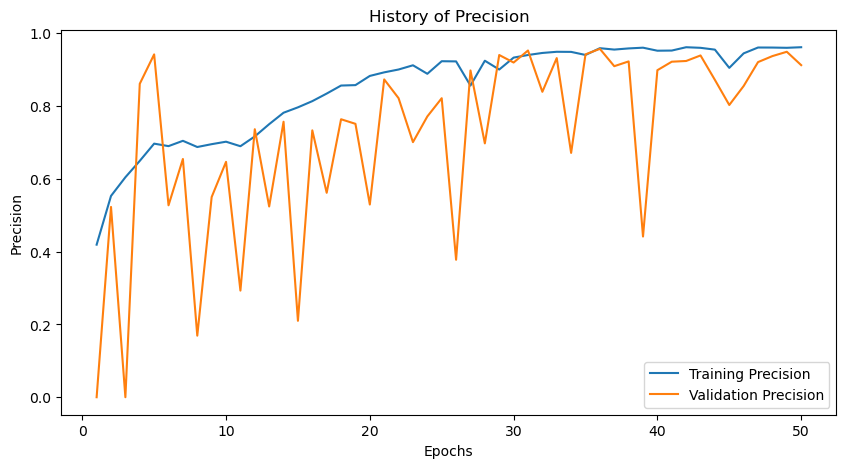

In [57]:
def plot_accuracy(acc, val_acc):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(acc) + 1), acc, label='Training Accuracy')
    plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
    plt.title('History of Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_loss(loss, val_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(loss) + 1), loss, label='Training Loss')
    plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
    plt.title('History of Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_auc(auc, val_auc):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(auc) + 1), auc, label='Training AUC')
    plt.plot(range(1, len(val_auc) + 1), val_auc, label='Validation AUC')
    plt.title('History of AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.show()

def plot_precision(precision, val_precision):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(precision) + 1), precision, label='Training Precision')
    plt.plot(range(1, len(val_precision) + 1), val_precision, label='Validation Precision')
    plt.title('History of Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

# Call each function separately
plot_accuracy(model_history.history['accuracy'], model_history.history['val_accuracy'])
plot_loss(model_history.history['loss'], model_history.history['val_loss'])
plot_auc(model_history.history['auc'], model_history.history['val_auc'])
plot_precision(model_history.history['precision'], model_history.history['val_precision'])


##Classification Report

In [52]:
CLASSES = ['MildDemented','ModerateDemented','NonDemented','VeryMildDemented']
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

    MildDemented       0.99      0.99      0.99       179
ModerateDemented       1.00      1.00      1.00        12
     NonDemented       1.00      0.96      0.98       640
VeryMildDemented       0.95      1.00      0.97       448

       micro avg       0.98      0.98      0.98      1279
       macro avg       0.98      0.99      0.99      1279
    weighted avg       0.98      0.98      0.98      1279
     samples avg       0.98      0.98      0.98      1279



##Grad-CAM Heatmap Visualization

1/1 [==============================] - 0s 119ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


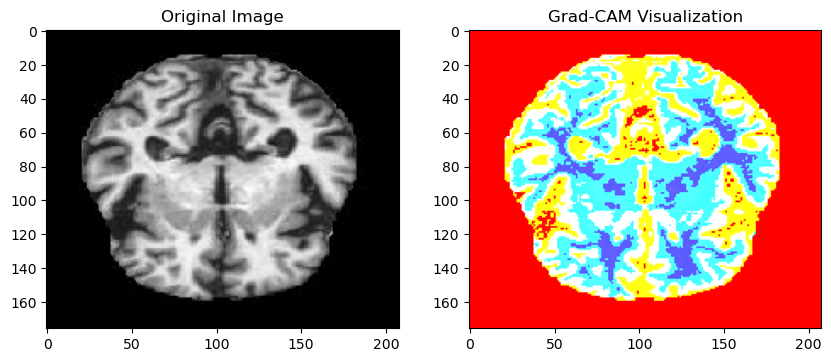

1/1 [==============================] - 0s 121ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


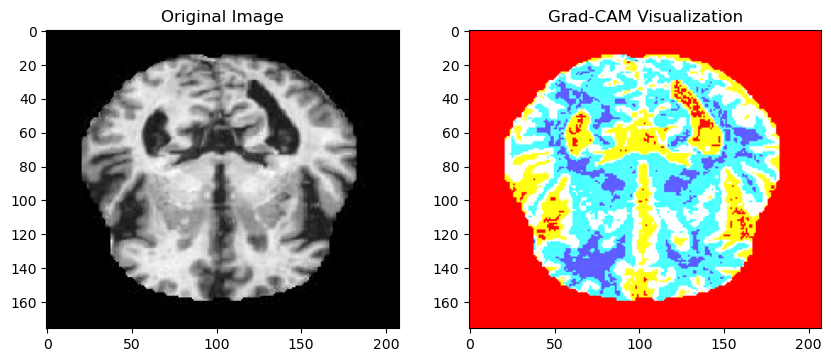

1/1 [==============================] - 0s 123ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


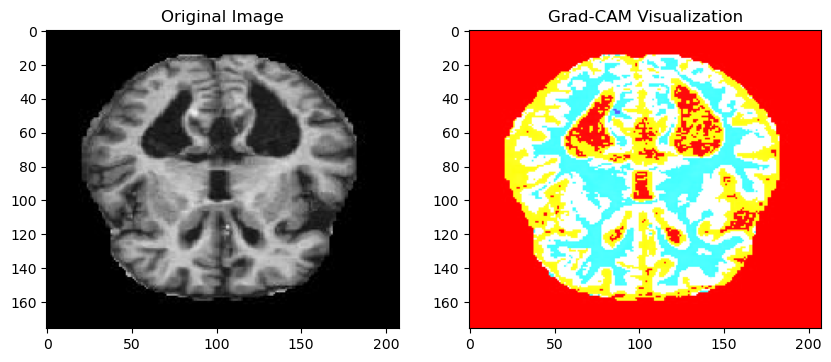

1/1 [==============================] - 0s 118ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


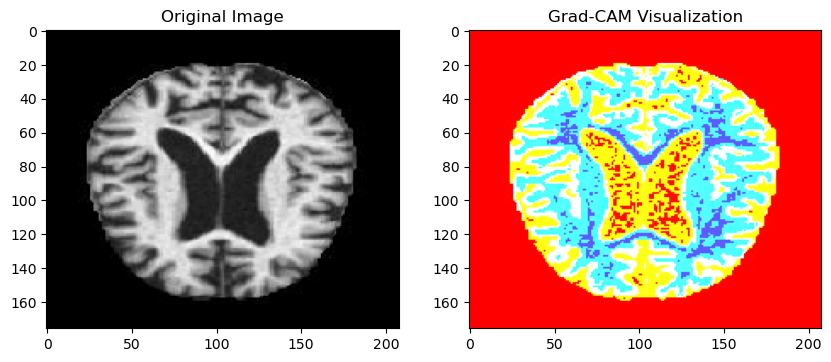

In [53]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def generate_grad_cam(image_path):
    sample_img = image.load_img(image_path, target_size=IMAGE_SIZE)
    sample_img_array = image.img_to_array(sample_img)
    sample_img_array = np.expand_dims(sample_img_array, axis=0)
    sample_img_array /= 255.0  

    model = tf.keras.models.load_model('model.h5')

    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer('conv2d_7').output, model.output]
    )

    pred_index = np.argmax(model.predict(sample_img_array), axis=1)[0]

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(sample_img_array)
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(conv_outputs[0], pooled_grads), axis=-1)

    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    heatmap = tf.image.resize(tf.expand_dims(heatmap, axis=-1), (sample_img_array.shape[1], sample_img_array.shape[2]))
    heatmap = tf.squeeze(heatmap).numpy()

    superimposed_img = sample_img_array[0] * 255.0
    superimposed_img = np.uint8(superimposed_img)
    superimposed_img = cv2.applyColorMap(superimposed_img, cv2.COLORMAP_JET)
    superimposed_img = superimposed_img.astype(sample_img_array[0].dtype)
    superimposed_img = cv2.addWeighted(superimposed_img, 0.6, sample_img_array[0], 0.4, 0)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(sample_img)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title('Grad-CAM Visualization')
    plt.show()


generate_grad_cam('/Users/nandinielangovan/Alzheimers_Classification/Alzheimer_s Dataset/train/MildDemented/mildDem23.jpg')
generate_grad_cam('/Users/nandinielangovan/Alzheimers_Classification/Alzheimer_s Dataset/train/NonDemented/nonDem28.jpg')
generate_grad_cam('/Users/nandinielangovan/Alzheimers_Classification/Alzheimer_s Dataset/train/VeryMildDemented/verymildDem32.jpg')
generate_grad_cam('/Users/nandinielangovan/Alzheimers_Classification/Alzheimer_s Dataset/train/ModerateDemented/moderateDem48.jpg')


In [49]:
y_pred = modelCategorical.predict(X_test)

40/40 [==============================] - 5s 112ms/step
